In [100]:
import pandas as pd
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid", palette="pastel", color_codes=True)

load_dotenv()
os.chdir(os.getenv("ROOT_DIR"))

In [101]:
# --- PARAMS --- #
train_data_path = os.getenv("DF_TRAIN_PATH")
test_data_path = os.getenv("DF_NEW_DATA_PATH")

print(train_data_path)
print(test_data_path)

data/raw/train.csv
data/raw/test.csv


In [102]:
# --- LOAD DATA --- #
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

train_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [103]:
# Project
### 1. Check consistency
### 2. Parsing: Get titles
### 3. Preprocessing titles
### 4. Check correlation with target
### 5. Multivariate Analysis

### Check consistency

In [104]:
print(train_data['Name'].isna().sum(), test_data['Name'].isna().sum())

# not nan values

0 0


In [105]:
print(train_data['Name'].nunique(), test_data['Name'].nunique())

# all unique values

891 418


In [106]:
train_data['Name'].sample(10)

800                                Ponesell, Mr. Martin
276                   Lindblom, Miss. Augusta Charlotta
366    Warren, Mrs. Frank Manley (Anna Sophia Atkinson)
55                                    Woolner, Mr. Hugh
727                            Mannion, Miss. Margareth
237                    Collyer, Miss. Marjorie "Lottie"
561                                   Sivic, Mr. Husein
333                     Vander Planke, Mr. Leo Edmondus
56                                    Rugg, Miss. Emily
322                           Slayter, Miss. Hilda Mary
Name: Name, dtype: object

### Parsing: get titles

In [107]:
regex_title = r',\s*(\w*)'
train_data['title'] = train_data['Name'].str.extract(regex_title)
train_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs


### 3. Preprocessing titles

In [108]:
train_data.title.value_counts()

title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
the           1
Jonkheer      1
Name: count, dtype: int64

In [109]:
train_data.title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the', 'Jonkheer'],
      dtype=object)

In [110]:
# 
title_mapping = {
    'Mme' : 'Mrs',
    'Mlle': 'Miss',
    'Ms' : 'Miss',
    'Don' : 'Sir',
    'Jonkheer':'Sir',
    'Major':'Military',
    'Capt': 'Military',
    'the' : 'Mrs',
    'Lady': 'Mrs',
    'Col' : 'Military'
}

train_data['title'] = train_data['title'].replace(title_mapping)
train_data['title'].value_counts()


title
Mr          517
Miss        185
Mrs         128
Master       40
Dr            7
Rev           6
Military      5
Sir           3
Name: count, dtype: int64

### 4. Check correlation with target

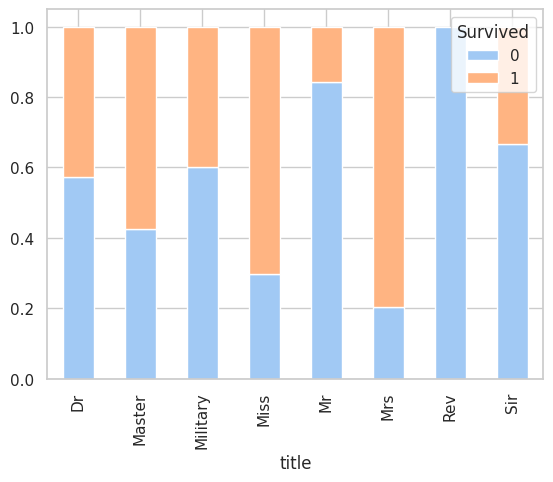

In [111]:
# Barplot
pd.crosstab(train_data['title'], train_data['Survived'], normalize='index').plot(kind='bar', stacked=True)
plt.show()

# It seems that some titles have a higher survival rate than others. However, it is not 
# clear if this is to the title itself or for others factors as Age or Sex.

### 5. Multivariate Analysis

In [146]:
# LR version 1
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

imputer_age_mean = SimpleImputer(strategy='mean')
imputer_age_mean.fit(train_data['Age'].values.reshape(-1, 1))
train_data['Age2'] = imputer_age_mean.transform(train_data['Age'].values.reshape(-1, 1))

x = pd.get_dummies(train_data, columns=['Pclass', 'title'], drop_first=True)


x = x[['Age2', 'Pclass_2', 'Pclass_3',
       'title_Master', 'title_Military', 'title_Miss', 'title_Mr', 'title_Mrs',
       'title_Rev', 'title_Sir']].astype('float')
x = sm.add_constant(x)
y = train_data['Survived']

model = sm.Logit(y,x).fit()
print(model.summary())

         Current function value: 0.434133
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      880
Method:                           MLE   Df Model:                           10
Date:                Wed, 23 Oct 2024   Pseudo R-squ.:                  0.3481
Time:                        05:45:51   Log-Likelihood:                -386.81
converged:                      False   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.583e-82
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7306      0.864      0.845      0.398      -0.963       2.425
Age2              -0.0180      0.008     -2.123      

/home/gonzalo/Documents/notes/p-ds-structure-01/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [147]:
# Logistic Regression version 2
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

imputer_age_mean = SimpleImputer(strategy='mean')
imputer_age_mean.fit(train_data['Age'].values.reshape(-1, 1))
train_data['Age2'] = imputer_age_mean.transform(train_data['Age'].values.reshape(-1, 1))

x = pd.get_dummies(train_data, columns=['Pclass', 'title'], drop_first=True)


x = x[['title_Master', 'title_Military', 'title_Miss', 'title_Mr', 'title_Mrs',
       'title_Rev', 'title_Sir']].astype('float')
x = sm.add_constant(x)
y = train_data['Survived']

model = sm.Logit(y,x).fit()
print(model.summary())

         Current function value: 0.492649
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      883
Method:                           MLE   Df Model:                            7
Date:                Wed, 23 Oct 2024   Pseudo R-squ.:                  0.2602
Time:                        05:47:15   Log-Likelihood:                -438.95
converged:                      False   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 8.159e-63
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.2877      0.764     -0.377      0.706      -1.785       1.209
title_Master       0.5900      0.828      0.712      

/home/gonzalo/Documents/notes/p-ds-structure-01/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [148]:
# It seems that Mrs. is a good predictor of survival, 
# at leat. The other titles seems to be not significant.

# INSIGHT-1: The title Mrs. is a good predictor of survival. 

### Results

- INSIGHT-1: The title Mrs. is a good predictor of survival. 

We add title to the model. However, we have to prioritize Mrs., and Miss. We need to consider different possibilities of preprocessing, At least `['title_Master', 'title_Military', 'title_Miss', 'title_Mr', 'title_Mrs','title_Rev', 'title_Sir']` and `['title_Miss', 'title_Mrs','others']`.
